In [1]:
import sys
sys.path.append('..')
from os.path import join, exists
from collections import OrderedDict
from pickle import load
from tqdm import tqdm

from search_state import DerivationTreeNode, Operation

In [2]:
######################
# Old representation #
######################
#
# architecture = OrderedDict(
#     {
#         "fn": routing_module,
#         "children": OrderedDict(
#             {
#                 "prerouting_fn": OrderedDict({"fn": im2col1k2s0p}),
#                 "inner_fn": OrderedDict(
#                     {
#                         "fn": computation_module,
#                         "children": OrderedDict(
#                             {
#                                 "computation_fn": linear512
#                             }
#                         ),
#                     }
#                 ),
#                 "postrouting_fn": OrderedDict({"fn": col2im}),
#             }
#         ),
#     }
# )
#

######################
# New representation #
######################
#
# [
#     DerivationTreeNode(id=1, level=network, operation=Operation(routing, nonterminal, ['prerouting_fn', 'module', 'postrouting_fn'])),
#     DerivationTreeNode(id=2, level=prerouting_fn, operation=Operation(im2col(1, 2, 0), terminal, [])),
#     DerivationTreeNode(id=3, level=module, operation=Operation(computation, nonterminal, ['computation_fn'])),
#     DerivationTreeNode(id=4, level=computation_fn, operation=Operation(linear512, terminal, [])),
#     DerivationTreeNode(id=5, level=postrouting_fn, operation=Operation(col2im, terminal, [])),
# ]

In [3]:
from einspace.layers import *

class Converter:
    ops = [
        sequential_module,
        branching_module,
        routing_module,
        sequential_module,
        branching_module,
        routing_module,
        computation_module,
        clone_tensor2,
        clone_tensor4,
        clone_tensor8,
        group_dim2s1d,
        group_dim2s2d,
        group_dim2s3d,
        group_dim4s1d,
        group_dim4s2d,
        group_dim4s3d,
        group_dim8s1d,
        group_dim8s2d,
        group_dim8s3d,
        dot_product,
        scaled_dot_product,
        add_tensors,
        cat_tensors1d2t,
        cat_tensors2d2t,
        cat_tensors3d2t,
        cat_tensors1d4t,
        cat_tensors2d4t,
        cat_tensors3d4t,
        cat_tensors1d8t,
        cat_tensors2d8t,
        cat_tensors3d8t,
        identity,
        permute21,
        permute132,
        permute213,
        permute231,
        permute312,
        permute321,
        im2col1k1s0p,
        im2col1k2s0p,
        im2col3k1s1p,
        im2col3k2s1p,
        im2col4k4s0p,
        im2col8k8s0p,
        im2col16k16s0p,
        identity,
        permute21,
        permute132,
        permute213,
        permute231,
        permute312,
        permute321,
        col2im,
        identity,
        linear16,
        linear32,
        linear64,
        linear128,
        linear256,
        linear512,
        linear1024,
        linear2048,
        norm,
        leakyrelu,
        softmax,
        learnable_positional_encoding,
    ]

    def translate_name(self, name):
        if name in ["sequential", "routing", "branching(2)", "branching(4)", "branching(8)", "computation"]:
            name = name.replace("(", "").replace("2", "").replace("4", "").replace("8", "").replace(")", "")
            name += "_module"
        if "im2col" in name:
            # convert im2col(a, b, c) to im2colakbscp for any a, b and c
            # extract a, b and c
            a, b, c = map(lambda x: x.strip(), name.split("(")[1].split(")")[0].split(","))
            # insert a, b and c in the new name
            name = f"im2col{a}k{b}s{c}p"
        if "clone" in name:
            # convert clone(a) to clonea for any a
            a = name.split("(")[1].split(")")[0]
            name = f"clone_tensor{a}"
        if "group" in name:
            # convert group(a, b) to group_dimasbd for any a, b
            a, b = map(lambda x: x.strip(), name.split("(")[1].split(")")[0].split(","))
            name = f"group_dim{a}s{b}d"
        if "cat" in name:
            # convert cat(a, b) to cat_tensorsbdat for any a, b
            a, b = map(lambda x: x.strip(), name.split("(")[1].split(")")[0].split(","))
            name = f"cat_tensors{b}d{a}t"
        if "dot_product" in name:
            if "scaled" in name:
                # convert dot_product(scaled=True) to scaled_dot_product
                name = "scaled_dot_product"
            else:
                # convert dot_product to dot_product
                name = "dot_product"
        if "add" in name:
            # convert add to add
            name = "add_tensors"
        if "perm" in name:
            # if two commas
            if name.count(",") == 2:
                # convert perm(0, 2, 1) to permute21
                a, b, c = map(lambda x: x.strip(), name.split("(")[1].split(")")[0].split(","))
                name = f"permute{b}{c}"
            # if three commas
            elif name.count(",") == 3:
                # convert perm(0, 2, 3, 1) to permute231
                a, b, c, d = map(lambda x: x.strip(), name.split("(")[1].split(")")[0].split(","))
                name = f"permute{b}{c}{d}"
        if "linear" in name:
            # convert linear(a) to lineara for any a
            a = name.split("(")[1].split(")")[0]
            name = f"linear{a}"
        if "relu" in name:
            # convert relu to leakyrelu
            name = "leakyrelu"
        if "pos_enc" in name:
            # convert positional_encoding to learnable_positional_encoding
            name = "learnable_positional_encoding"
        return name

    def convert_to_old(self, root):
        """
        Convert any architecture from the new representation to the old representation
        In a recursive manner that can handle any depth of the architecture
        Input:
            root: DerivationTreeNode (with children)
        Output:
            OrderedDict
        """
        if root.operation.name == "sequential":
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "children": OrderedDict({
                    "first_fn": self.convert_to_old(root.children[0]),
                    "second_fn": self.convert_to_old(root.children[1]),
                }),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "nonterminal",
                "node_id": root.id,
            })
        elif root.operation.name == "routing":
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "children": OrderedDict({
                    "prerouting_fn": self.convert_to_old(root.children[0]),
                    "inner_fn": self.convert_to_old(root.children[1]),
                    "postrouting_fn": self.convert_to_old(root.children[2]),
                }),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "nonterminal",
                "node_id": root.id,
            })
        elif root.operation.name == "branching(2)":
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "children": OrderedDict({
                    "branching_fn": self.convert_to_old(root.children[0]),
                    "inner_fn": [
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[2]),
                    ],
                    "aggregation_fn": self.convert_to_old(root.children[3]),
                }),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "nonterminal",
                "node_id": root.id,
            })
        elif root.operation.name == "branching(4)":
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "children": OrderedDict({
                    "branching_fn": self.convert_to_old(root.children[0]),
                    "inner_fn": [
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                    ],
                    "aggregation_fn": self.convert_to_old(root.children[2]),
                }),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "nonterminal",
                "node_id": root.id,
            })
        elif root.operation.name == "branching(8)":
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "children": OrderedDict({
                    "branching_fn": self.convert_to_old(root.children[0]),
                    "inner_fn": [
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                        self.convert_to_old(root.children[1]),
                    ],
                    "aggregation_fn": self.convert_to_old(root.children[2]),
                }),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "nonterminal",
                "node_id": root.id,
            })
        elif root.operation.name == "computation":
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "children": OrderedDict({
                    "computation_fn": self.convert_to_old(root.children[0]),
                }),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "nonterminal",
                "node_id": root.id,
            })
        elif root.is_leaf():
            return OrderedDict({
                "fn": eval(self.translate_name(root.operation.name)),
                "input_shape": root.input_params["shape"],
                "output_shape": root.output_params["shape"],
                "input_branching_factor": root.input_params["branching_factor"],
                "output_branching_factor": root.output_params["branching_factor"],
                "depth": root.depth,
                "node_type": "terminal",
                "node_id": root.id,
            })
        else:
            raise ValueError(f"Unknown level {root.level}")

    def convert_to_new(self, root):
        """
        Convert any architecture from the old representation to the new representation
        In a recursive manner that can handle any depth of the architecture
        Input:
            root: OrderedDict (with children)
        Output:
            DerivationTreeNode
        """
        raise NotImplementedError

In [4]:
converter = Converter()

# test it
assert converter.translate_name("sequential") == "sequential_module"
assert converter.translate_name("routing") == "routing_module"
assert converter.translate_name("branching(2)") == "branching_module"
assert converter.translate_name("branching(4)") == "branching_module"
assert converter.translate_name("branching(8)") == "branching_module"
assert converter.translate_name("computation") == "computation_module"
assert converter.translate_name("im2col(1,2,0)") == "im2col1k2s0p"
assert converter.translate_name("im2col(16,16,8)") == "im2col16k16s8p"
assert converter.translate_name("clone(2)") == "clone_tensor2"
assert converter.translate_name("clone(4)") == "clone_tensor4"
assert converter.translate_name("clone(8)") == "clone_tensor8"
assert converter.translate_name("group(1,2)") == "group_dim1s2d"
assert converter.translate_name("group(8,1)") == "group_dim8s1d"
assert converter.translate_name("cat(2,1)") == "cat_tensors1d2t"
assert converter.translate_name("cat(4,2)") == "cat_tensors2d4t"
assert converter.translate_name("cat(8,3)") == "cat_tensors3d8t"
assert converter.translate_name("dot_product(scaled=True)") == "scaled_dot_product"
assert converter.translate_name("add(2)") == "add_tensors"
assert converter.translate_name("add(4)") == "add_tensors"
assert converter.translate_name("add(8)") == "add_tensors"
assert converter.translate_name("permute(0,2,1)") == "permute21"
assert converter.translate_name("permute(0,2,3,1)") == "permute231"
assert converter.translate_name("linear(16)") == "linear16"
assert converter.translate_name("relu") == "leakyrelu"
assert converter.translate_name("pos_enc") == "learnable_positional_encoding"

In [5]:
architecture = [
    DerivationTreeNode(id=1, level="network",
        operation=Operation("routing", "nonterminal", ['prerouting_fn', 'module', 'postrouting_fn'], None, None, None, None),
        input_params={"shape": [1, 3, 32, 32], "branching_factor": 1}
    ),
    DerivationTreeNode(id=2, level="prerouting_fn",
        operation=Operation("im2col(1, 2, 0)", "terminal", [], None, None, None, None),
        input_params={"shape": [1, 3, 32, 32], "branching_factor": 1}
    ),
    DerivationTreeNode(id=3, level="module",
        operation=Operation("computation", "nonterminal", ['computation_fn'], None, None, None, None),
        input_params={"shape": [1, 256, 3], "branching_factor": 1}
    ),
    DerivationTreeNode(id=4, level="computation_fn",
        operation=Operation("linear(512)", "terminal", [], None, None, None, None),
        input_params={"shape": [1, 256, 512], "branching_factor": 1}
    ),
    DerivationTreeNode(id=5, level="postrouting_fn",
        operation=Operation("col2im", "terminal", [], None, None, None, None),
        input_params={"shape": [1, 512, 16, 16], "branching_factor": 1}
    ),
]
# set output_params
architecture[0].output_params = {"shape": [1, 512, 16, 16], "branching_factor": 1}
architecture[1].output_params = {"shape": [1, 256, 3], "branching_factor": 1}
architecture[2].output_params = {"shape": [1, 256, 512], "branching_factor": 1}
architecture[3].output_params = {"shape": [1, 256, 512], "branching_factor": 1}
architecture[4].output_params = {"shape": [1, 512, 16, 16], "branching_factor": 1}

# connect the children
architecture[0].children = [architecture[1], architecture[2], architecture[4]
]
architecture[2].children = [architecture[3]]
# convert the architecture
converter = Converter()
converted_architecture = converter.convert_to_old(architecture[0])
print(converted_architecture)

OrderedDict([('fn', <function routing_module at 0x7fab0c598820>), ('children', OrderedDict([('prerouting_fn', OrderedDict([('fn', <function im2col1k2s0p at 0x7fab0c599090>), ('input_shape', [1, 3, 32, 32]), ('output_shape', [1, 256, 3]), ('input_branching_factor', 1), ('output_branching_factor', 1), ('depth', 0), ('node_type', 'terminal'), ('node_id', 2)])), ('inner_fn', OrderedDict([('fn', <function computation_module at 0x7fab0c5988b0>), ('children', OrderedDict([('computation_fn', OrderedDict([('fn', <function linear512 at 0x7fab0c59a200>), ('input_shape', [1, 256, 512]), ('output_shape', [1, 256, 512]), ('input_branching_factor', 1), ('output_branching_factor', 1), ('depth', 0), ('node_type', 'terminal'), ('node_id', 4)]))])), ('input_shape', [1, 256, 3]), ('output_shape', [1, 256, 512]), ('input_branching_factor', 1), ('output_branching_factor', 1), ('depth', 0), ('node_type', 'nonterminal'), ('node_id', 3)])), ('postrouting_fn', OrderedDict([('fn', <function col2im at 0x7fab0c599

In [6]:
import sys
sys.path.append("../")
from pickle import dump, load, Unpickler
import search_state
from main import compile_fn

In [7]:
import io
import torch

class CPU_Unpickler(Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [8]:
from einspace.search_spaces import EinSpace
from einspace.compiler import Compiler
from einspace.utils import (
    ArchitectureCompilationError,
    SearchSpaceSamplingError,
    get_average_branching_factor,
    get_max_depth,
    get_size,
    millify,
    recurse_count_nodes,
)


class Individual(object):
    """A class representing a model containing an architecture, its modules and its accuracy."""

    def __init__(
        self,
        id,
        parent_id,
        arch=None,
        modules=None,
        accuracy=None,
        age=0,
        hpo_dict=None,
    ):
        self.id = id
        self.parent_id = parent_id
        self.arch = arch
        # self.modules = modules
        self.accuracy = accuracy
        self.age = age
        self.hpo_dict = hpo_dict

        self.alive = True

        self.feature_shape = arch["output_shape"]
        self.num_parameters = sum([p.numel() for p in modules.parameters()])
        self.num_terminals = get_size(arch, "terminal")
        self.num_nonterminals = get_size(arch, "nonterminal")
        self.average_branching_factor = get_average_branching_factor(arch)
        # except:
        #     print(f"Error while calculating average branching factor for individual {self.id}")
        #     self.average_branching_factor = 0
        self.max_depth = get_max_depth(arch)
        # except:
        #     print(f"Error while calculating max depth for individual {self.id}")
        #     self.max_depth = 0

        self.nodes = {
            node.__name__: 0
            for node in (
                EinSpace.modules
                + EinSpace.branching_fns
                + EinSpace.aggregation_fns
                + EinSpace.prerouting_fns
                + EinSpace.postrouting_fns
                + EinSpace.computation_fns
            )
        }

    def get_descriptor(self):
        # return a simple vector representation of the individual including all numerical features
        return [
            self.feature_shape[1],
            self.num_parameters,
            self.num_terminals,
            self.num_nonterminals,
            self.average_branching_factor,
            self.max_depth,
            *recurse_count_nodes(self.arch, self.nodes).values(),
        ]

    def get_named_descriptor(self):
        # return a simple vector representation of the individual including all numerical features
        named_descriptor = {
            "feature_shape": self.feature_shape[1],
            "num_parameters": self.num_parameters,
            "num_terminals": self.num_terminals,
            "num_nonterminals": self.num_nonterminals,
            "average_branching_factor": self.average_branching_factor,
            "max_depth": self.max_depth,
        }
        named_descriptor.update(recurse_count_nodes(self.arch, self.nodes))
        return named_descriptor

    def __repr__(self):
        """Prints a readable version of this bitstring."""
        return f"Individual(id={self.id}, accuracy={self.accuracy}, age={self.age}, feature_shape={self.feature_shape}, num_parameters={millify(self.num_parameters)}, num_terminals={self.num_terminals}, num_nonterminals={self.num_nonterminals}, average_branching_factor={self.average_branching_factor}, hpo_dict={self.hpo_dict})"


In [9]:
converter = Converter()
compiler = Compiler()
data = []
id = 0
for seed in range(8):
    f = open(f"../results/einspace/cifar10/evolution/seed={seed}/backtrack=True/mode=iterative/time_limit=300/max_id_limit=10000/depth_limit=20/mem_limit=8192/regularised=True/population_size=100/architecture_seed=None/mutation_strategy=random/mutation_rate=1.0/crossover_strategy=two_point/crossover_rate=0.5/selection_strategy=tournament/tournament_size=10/elitism=False/search_results.pkl", "rb")
    ckpt = CPU_Unpickler(f).load()
    for i in tqdm(range(len(ckpt["rewards"])), desc="Converting architectures"):
        architecture, reward, _, _ = ckpt["rewards"][i]
        old_representation = converter.convert_to_old(architecture[0])
        data.append(Individual(
            id=id,
            parent_id=None,
            arch=old_representation,
            modules=compiler.compile(old_representation),
            accuracy=reward,
            age=0
        ))
        id += 1
print(len(data))
print(data[0])
import pickle
pickle.dump({"cifar10": data}, open("benchmark_cifar10.pkl", "wb"))

Converting architectures: 100%|██████████| 1187/1187 [02:35<00:00,  7.62it/s]


8491
Individual(id=0, accuracy=0.3876, age=0, feature_shape=torch.Size([1, 256, 32]), num_parameters=61K, num_terminals=34, num_nonterminals=33, average_branching_factor=7.794117647058823, hpo_dict=None)


0.7912

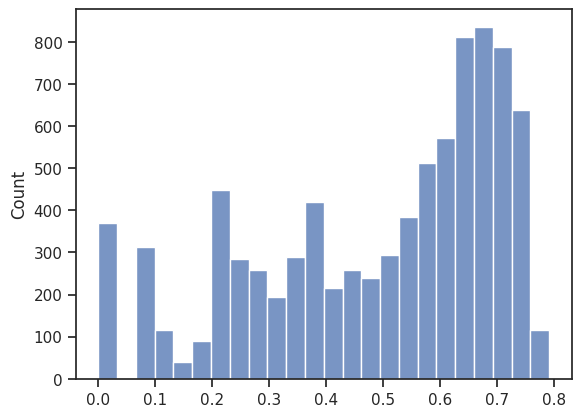

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot([individual.accuracy for individual in data])
print(max([individual.accuracy for individual in data]))

In [11]:
import pickle

benchmark = pickle.load(open("benchmark3.pkl", "rb"))

In [12]:
benchmark.keys()

dict_keys(['cifar10', 'cifar100', 'ninapro', 'darcyflow', 'psicov', 'ecg', 'satellite', 'deepsea'])

In [13]:
benchmark["cifar10"][0].arch

OrderedDict([('fn', <function einspace.layers.sequential_module(**kwargs)>),
             ('children',
              OrderedDict([('first_fn',
                            OrderedDict([('fn',
                                          <function einspace.layers.sequential_module(**kwargs)>),
                                         ('children',
                                          OrderedDict([('first_fn',
                                                        OrderedDict([('fn',
                                                                      <function einspace.layers.sequential_module(**kwargs)>),
                                                                     ('children',
                                                                      OrderedDict([('first_fn',
                                                                                    OrderedDict([('fn',
                                                                                                  <func

In [14]:
from collections import Counter
from rich import print
import pandas as pd

architectures = []
for dataset in ["addnist", "language", "multnist", "cifartile", "gutenberg", "isabella", "geoclassing", "chesseract"]:
    try:    
        with open(f"../results/einspace/{dataset}/evolution/seed=0/backtrack=True/mode=iterative/time_limit=300/max_id_limit=10000/depth_limit=20/mem_limit=4096/regularised=True/population_size=100/mutation_strategy=random/mutation_rate=1.0/crossover_strategy=two_point/crossover_rate=0.5/selection_strategy=tournament/tournament_size=10/elitism=False/search_results.pkl", "rb") as f:
            results = load(f)
            architectures.extend(results["rewards"])
    except FileNotFoundError:
        pass

print(len(architectures))

counts = Counter()
for i in range(len(architectures)):
    counts.update([node.operation.name for node in architectures[i][0]])

print(counts.most_common())

5000

[
    ('computation', 44143),
    ('identity', 37427),
    ('sequential', 36162),
    ('routing', 34610),
    ('perm(0,2,1)', 24703),
    ('branching(4)', 9066),
    ('branching(8)', 8319),
    ('relu', 5516),
    ('linear(16)', 4544),
    ('linear(32)', 4466),
    ('linear(256)', 4112),
    ('linear(1024)', 4105),
    ('clone(4)', 3933),
    ('norm', 3849),
    ('add(4)', 3661),
    ('clone(8)', 3576),
    ('linear(64)', 3076),
    ('add(8)', 3028),
    ('branching(2)', 2981),
    ('cat(4,1)', 2934),
    ('group(4,2)', 2865),
    ('cat(8,2)', 2802),
    ('linear(2048)', 2662),
    ('linear(512)', 2536),
    ('cat(4,2)', 2405),
    ('linear(128)', 2354),
    ('pos_enc', 2310),
    ('group(4,1)', 2160),
    ('perm(0,2,1,3)', 1838),
    ('group(8,1)', 1770),
    ('group(2,2)', 1720),
    ('group(8,3)', 1693),
    ('cat(8,1)', 1636),
    ('cat(2,2)', 1595),
    ('softmax', 1535),
    ('group(8,2)', 1280),
    ('perm(0,3,1,2)', 1031),
    ('group(2,1)', 993),
    ('im2col(1,1,0)', 951),
    ('im2col(1,2,0)', 925),
    ('perm(0,2,3,1)', 905),
    ('im2col(4,4,0)', 867),
    ('cat(8,3)', 853),
    ('perm(0,1,3,2)', 836),
    ('im2col(16,16,0)', 828),
    ('im2col(3,2,1)', 827),
    ('cat(2,1)', 811),
    ('perm(0,3,2,1)', 803),
    ('dot_product', 360),
    ('clone(2)', 244),
    ('col2im', 239),
    ('add(2)', 124),
    ('group(4,3)', 108),
    ('cat(4,3)', 66),
    ('im2col(8,8,0)', 64),
    ('cat(2,3)', 61),
    ('im2col(3,1,1)', 54),
    ('dot_product(scaled)', 30),
    ('group(2,3)', 24)
]

In [15]:
df = pd.DataFrame().from_dict(counts, orient="index").reset_index().rename(columns={"index": "operation", 0: "count"}).sort_values("count", ascending=False)

In [16]:
df

,operation,count
6,computation,44143
14,identity,37427
15,sequential,36162
4,routing,34610
20,"perm(0,2,1)",24703
2,branching(4),9066
0,branching(8),8319
31,relu,5516
22,linear(16),4544
26,linear(32),4466


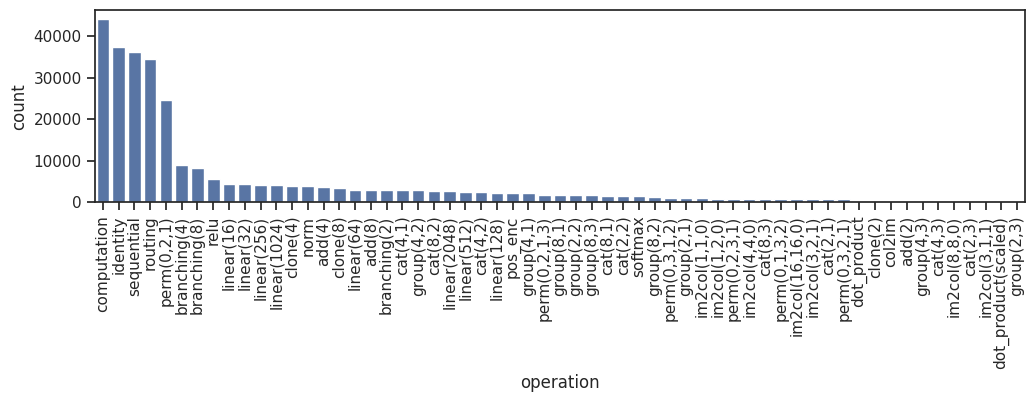

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

plt.figure(figsize=(12, 2.5))
sns.barplot(df, x="operation", y="count", orient="v")
plt.xticks(rotation=90);